<a href="https://colab.research.google.com/github/AdebanjiAdelowo/Image_denoising_using_ResNet/blob/main/final_image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# IMPORTS
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import *
 
# Plotting library
import matplotlib.pyplot as plt
# Image library for converting to grayscale
from skimage import color

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


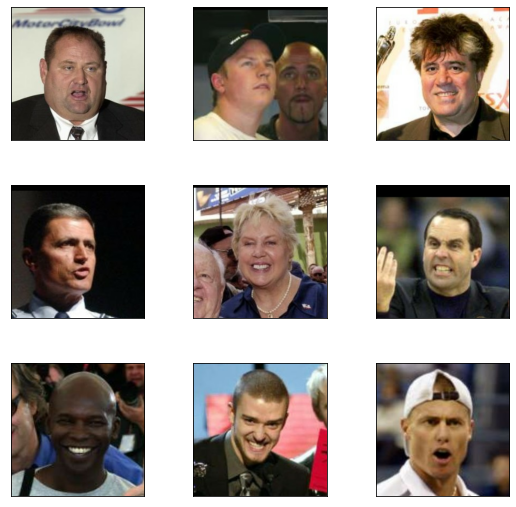

In [3]:
# Dataset "lfw" (https://www.tensorflow.org/datasets/catalog/lfw)
dataset, info = tfds.load("lfw", split="train", shuffle_files=True, with_info=True)
tfds.show_examples(info, dataset)
plt.show()

In [4]:
# Defines a function that returns a noisy version of an image.
# Parameters are the image and the standard derivation
# (sigma) of the Gaussian distribution.

def add_gaussian_noise(image, sigma):

  # Get Gaussian distributed random values with mean value 0
  noise = np.random.normal(0, sigma, image.shape)

  # Add the noise to the image
  noisy_image = image + noise

  # Clip the image to include only values between 0 and 1
  noisy_image = np.clip(noisy_image, 0, 1)

  # Return the noisy image
  return noisy_image

In [5]:
# Defines a function that adds salt-and-pepper noise to an image.
# Parameters are the image and the frequency, i.e. the probability that a 
# given pixel is replaced by either black or white.

def add_salt_and_pepper_noise(image, frequency):

  # Get uniformly distributed random values between 0 and 1
  # for every pixel in the original image
  noise = np.random.uniform(0, 1, image.shape)

  # Copy the original image
  noisy_image = image.copy()

  # All pixels for which the random value is smaller then frequency/2 is set
  # to black (thus the probability for a black pixel is frequency/2)
  noisy_image[noise <= frequency/2] = 0.0

  # Simililarly, all pixels for which the difference between the random value 
  # and 1 is smaller then frequency/2 are set to white
  noisy_image[1-noise <= frequency/2] = 1.0

  # Return the noisy image
  return noisy_image

In [6]:
# Retrieving the data

# Get a set of 50 images, randomized from the dataset
ds = dataset.shuffle(7000).take(5000)

# Convert to numpy format for manipulation (e.g. adding noise)
images_clean = [data["image"] for data in tfds.as_numpy(ds)]
images_clean = np.array(images_clean)

# Convert the color images to grayscale
images_clean = color.rgb2gray(images_clean)
images_clean = images_clean[:,:,:,np.newaxis]

In [7]:
images_noisy = add_gaussian_noise(images_clean, 0.09)

In [8]:
train_noisy = images_noisy[:3000]
train_clean = images_clean[:3000]

test_noisy = images_noisy[3000:]
test_clean = images_clean[3000:]
test_clean.shape

(2000, 250, 250, 1)

In [9]:
from tensorflow.keras.metrics import MSE, MSLE

In [10]:
def PSNR(orig, img):
    mse = MSE(orig.flatten(), img.flatten()).numpy()
    return 10 * np.log10(1/mse)

21.210918827832252


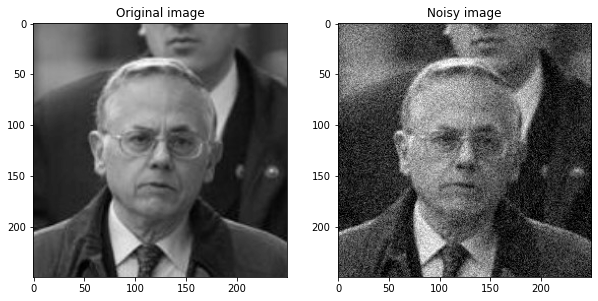

In [11]:
# Show an example of the Gaussian noise

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(test_clean[0,:,:,0], cmap="binary_r")
plt.title("Original image")

plt.subplot(122)
plt.imshow(test_noisy[0,:,:,0], cmap="binary_r")
plt.title("Noisy image")

print(PSNR(test_clean[0], test_noisy[0]))

plt.show()

In [12]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [13]:
def res_skip(input_tensor, num_channels):
    conv = Conv2D (num_channels,(3,3),padding='same')(input_tensor)
    relu = Activation('relu')(conv)
    conv2 = Conv2D (num_channels,(3,3),padding='same')(relu)
    add = Add()([input_tensor,conv2])
    output_tensor = Activation('relu')(add)
    return output_tensor


def build_nn_model(height, width, num_channels, num_res_blocks):
    inp = Input(shape=(height,width,1))
    conv = Conv2D (num_channels,(3,3),padding='same')(inp)
    block_out = Activation('relu')(conv)
    for i in np.arange(0,num_res_blocks):
        block_out = res_skip(block_out,num_channels)
    conv_m2 = Conv2D (1,(3,3),padding='same')(block_out)
    add_m1 = Add()([inp,conv_m2])
    model = Model(inputs = inp,  outputs = add_m1)
    return model

height = 250
width = 250
num_channels = 64
num_res_blocks = 3
model = build_nn_model(height,width,num_channels,num_res_blocks)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 250, 250, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 250, 250, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [14]:
height = 250
width = 250
num_channels = 64
num_res_blocks = 3
model = build_nn_model(height,width,num_channels,num_res_blocks)

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 250, 250, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 250, 250, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 activation_7 (Activation)      (None, 250, 250, 64  0           ['conv2d_8[0][0]']               
                                )                                                           

In [16]:
"""
opts = []
historys = []
opts.append(tf.keras.optimizers.SGD(learning_rate=0.1))
opts.append(tf.keras.optimizers.SGD(learning_rate=0.1, momentum = 0.9))
opts.append(tf.keras.optimizers.Adam())

for opt in opts:
  model.compile(optimizer=opt, loss="mean_squared_error", metrics= ['accuracy'])
  history = model.fit(train_noisy, train_clean,  epochs=30)
  historys.append(history)

"""

'\nopts = []\nhistorys = []\nopts.append(tf.keras.optimizers.SGD(learning_rate=0.1))\nopts.append(tf.keras.optimizers.SGD(learning_rate=0.1, momentum = 0.9))\nopts.append(tf.keras.optimizers.Adam())\n\nfor opt in opts:\n  model.compile(optimizer=opt, loss="mean_squared_error", metrics= [\'accuracy\'])\n  history = model.fit(train_noisy, train_clean,  epochs=30)\n  historys.append(history)\n\n'

In [17]:
"""
Y = range(1,31)
#plt.plot(historys[0].history['accuracy'], label ='SGD')
#plt.plot(historys[1].history['accuracy'], label ='SGD with MOM')
plt.plot(historys[0].history['accuracy'], label ='ADAM')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model Accuracy')
#plt.legend()
plt.show()
"""

"\nY = range(1,31)\n#plt.plot(historys[0].history['accuracy'], label ='SGD')\n#plt.plot(historys[1].history['accuracy'], label ='SGD with MOM')\nplt.plot(historys[0].history['accuracy'], label ='ADAM')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.title('Model Accuracy')\n#plt.legend()\nplt.show()\n"

In [18]:
"""
Y = range(1,31)
#plt.plot(historys[0].history['loss'], label ='SGD')
#plt.plot(historys[1].history['loss'], label ='SGD with MOM')
plt.plot(historys[0].history['loss'], label ='ADAM')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss')
#plt.legend()
plt.show()
"""

"\nY = range(1,31)\n#plt.plot(historys[0].history['loss'], label ='SGD')\n#plt.plot(historys[1].history['loss'], label ='SGD with MOM')\nplt.plot(historys[0].history['loss'], label ='ADAM')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.title('Model Loss')\n#plt.legend()\nplt.show()\n"

In [19]:
model.compile(optimizer= 'adam', loss="mean_squared_error", metrics= ['accuracy'])

In [20]:
history = model.fit(train_noisy, train_clean,  epochs=30)

Epoch 1/30
94/94 [==============================] - 162s 2s/step - loss: 0.0059 - accuracy: 0.0345
Epoch 2/30
94/94 [==============================] - 146s 2s/step - loss: 7.0982e-04 - accuracy: 0.0345
Epoch 3/30
94/94 [==============================] - 146s 2s/step - loss: 6.3683e-04 - accuracy: 0.0345
Epoch 4/30
94/94 [==============================] - 146s 2s/step - loss: 6.0695e-04 - accuracy: 0.0345
Epoch 5/30
94/94 [==============================] - 146s 2s/step - loss: 5.8234e-04 - accuracy: 0.0345
Epoch 6/30
94/94 [==============================] - 146s 2s/step - loss: 5.6764e-04 - accuracy: 0.0345
Epoch 7/30
94/94 [==============================] - 146s 2s/step - loss: 5.5952e-04 - accuracy: 0.0345
Epoch 8/30
94/94 [==============================] - 146s 2s/step - loss: 5.5064e-04 - accuracy: 0.0345
Epoch 9/30
94/94 [==============================] - 146s 2s/step - loss: 5.4393e-04 - accuracy: 0.0345
Epoch 10/30
94/94 [==============================] - 146s 2s/step - loss: 5.3

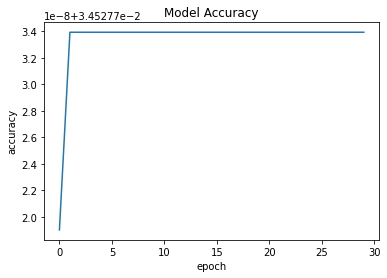

In [21]:
Y = range(1,31)
#plt.plot(historys[0].history['accuracy'], label ='SGD')
#plt.plot(historys[1].history['accuracy'], label ='SGD with MOM')
plt.plot(history.history['accuracy'], label ='ADAM')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Model Accuracy')
#plt.legend()
plt.show()

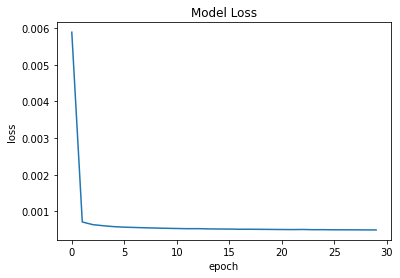

In [22]:
Y = range(1,31)
#plt.plot(historys[0].history['loss'], label ='SGD')
#plt.plot(historys[1].history['loss'], label ='SGD with MOM')
plt.plot(history.history['loss'], label ='ADAM')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Model Loss')
#plt.legend()
plt.show()

In [23]:
model.evaluate(test_noisy, test_clean)

63/63 [==============================] - 37s 576ms/step - loss: 4.8881e-04 - accuracy: 0.0371


[0.0004888094845227897, 0.037127409130334854]

In [24]:
test_denoised = model.predict(test_noisy)

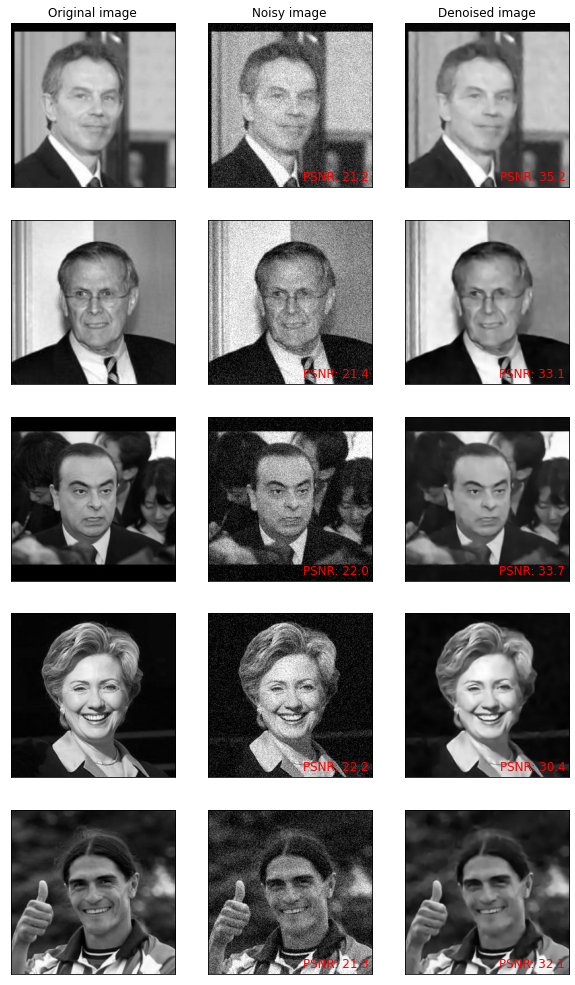

In [25]:
from matplotlib import pyplot as plt
nimg = 5
plt.figure(figsize=(10,3.5*nimg))

for i in range(nimg):

    randi = np.random.randint(0, test_clean.shape[0], 1)[0]
    
    plt.subplot(nimg, 3, 3*i+1)
    plt.imshow(test_clean[randi,:,:,0], cmap="binary_r")
    plt.xticks([])
    plt.yticks([])
    if i == 0: 
        plt.title("Original image")

    plt.subplot(nimg, 3, 3*i+2)
    plt.imshow(test_noisy[randi,:,:,0], cmap="binary_r")
    plt.xticks([])
    plt.yticks([])
    plt.annotate("PSNR: {:.1f}".format(PSNR(test_clean[randi], test_noisy[randi])),
                 (0.98,0.02), xycoords="axes fraction", va="bottom", ha="right", color="red", fontsize="large")
    if i == 0: 
        plt.title("Noisy image")

    plt.subplot(nimg, 3, 3*i+3)
    plt.imshow(test_denoised[randi,:,:,0], cmap="binary_r")
    plt.xticks([])
    plt.yticks([])
    plt.annotate("PSNR: {:.1f}".format(PSNR(test_clean[randi], test_denoised[randi])),
                 (0.98,0.02), xycoords="axes fraction", va="bottom", ha="right", color="red", fontsize="large")
    if i == 0: 
        plt.title("Denoised image")

plt.savefig("autoencoder_saltpepper.png", dpi=300, bbox_inches="tight", transparent=False)
plt.show()